# MLP 218
* Operate on 16000 GenCode 34 seqs.
* 5-way cross validation. Save best model per CV.
* Report mean accuracy from final re-validation with best 5.
* Use Adam with a learn rate decay schdule.

In [61]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
DATAPATH=""
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    NC_FILENAME = DATAPATH+NC_FILENAME
    PC_FILENAME = DATAPATH+PC_FILENAME
except:
    IN_COLAB = False
    DATAPATH="" 

EPOCHS=200
SPLITS=5
K=1
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
FILENAME='MLP218'
NEURONS=128

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

## Build model

In [63]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    opt = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    model.compile(loss=bc, optimizer=opt, metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model(maxlen):
    act="elu"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    #dense3_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    #dense4_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    #dense5_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation="sigmoid",dtype=dt)
    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    #mlp.add(dense3_layer)
    #mlp.add(dense4_layer)
    #mlp.add(dense5_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

## Load and partition sequences

In [64]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)



## Make K-mers

In [65]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1 -1:  # stop at minus one for spaced seed
            #kmer=seq[i:i+2]+seq[i+3:i+5]    # SPACED SEED 2/1/2 for K=4
            kmer=seq[i:i+K]  
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [66]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # From pandas dataframe to numpy to list to numpy
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [67]:
def make_frequencies(Xin):
    Xout=[]
    VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            freqs[kmerval] += 1
            total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

## Cross validation

In [68]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=DATAPATH+FILENAME+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [69]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=load_fasta(NC_FILENAME,0)
pc_seq=load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
print ("Compile the model")
model=build_model(MAXLEN)
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(DATAPATH+FILENAME+'.model')
print ("Data prep")
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train=make_frequencies(X_train)

Load data from files.
Ready: train_set
Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 17,409
Trainable params: 17,409
Non-trainable params: 0
_________________________________________________________________
None
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/MLP218.model/assets
Data prep
Data reshape


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5642 - accuracy: 0.7125 - val_loss: 0.5237 - val_accuracy: 0.7430
Epoch 2/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5529 - accuracy: 0.7157 - val_loss: 0.5299 - val_accuracy: 0.7368
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5490 - accuracy: 0.7181 - val_loss: 0.5277 - val_accuracy: 0.7368
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5461 - accuracy: 0.7179 - val_loss: 0.5516 - val_accuracy: 0.7424
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5488 - accuracy: 0.7163 - val_loss: 0.5288 - val_accuracy: 0.7381
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5436 - accuracy: 0.7215 - val_loss: 0.5360 - val_accuracy: 0.7250
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5463 - accuracy: 0.716

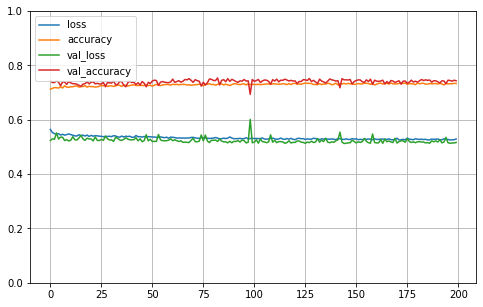

accuracy: 75.36%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5577 - accuracy: 0.7138 - val_loss: 0.5717 - val_accuracy: 0.7182
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5485 - accuracy: 0.7164 - val_loss: 0.5476 - val_accuracy: 0.7306
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5467 - accuracy: 0.7238 - val_loss: 0.5495 - val_accuracy: 0.7300
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5457 - accuracy: 0.7219 - val_loss: 0.5434 - val_accuracy: 0.7275
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5469 - accuracy: 0.7199 - val_loss: 0.5465 - val_accuracy: 0.7213
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5464 - accuracy: 0.7188 - val_loss: 0.5464 - val_accuracy: 0.7275
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5430 - accuracy: 0.71

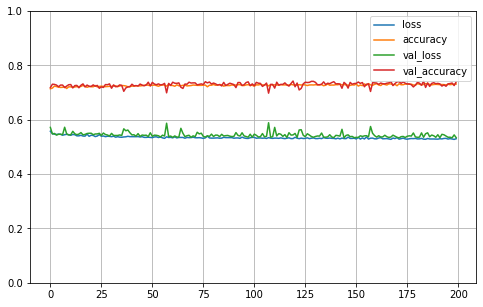

accuracy: 74.24%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5601 - accuracy: 0.7131 - val_loss: 0.5478 - val_accuracy: 0.7281
Epoch 2/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5518 - accuracy: 0.7183 - val_loss: 0.5512 - val_accuracy: 0.7213
Epoch 3/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5463 - accuracy: 0.7230 - val_loss: 0.5319 - val_accuracy: 0.7374
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5474 - accuracy: 0.7202 - val_loss: 0.5504 - val_accuracy: 0.7145
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5490 - accuracy: 0.7181 - val_loss: 0.5634 - val_accuracy: 0.7318
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5456 - accuracy: 0.7208 - val_loss: 0.5412 - val_accuracy: 0.7331
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5433 - accuracy: 0.72

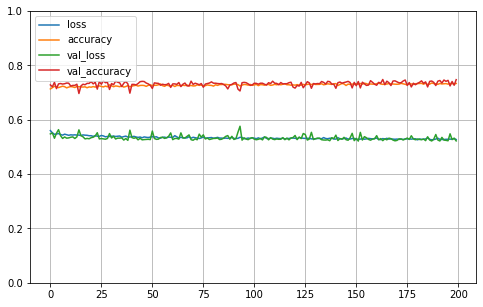

accuracy: 74.80%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5616 - accuracy: 0.7126 - val_loss: 0.5508 - val_accuracy: 0.7225
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5503 - accuracy: 0.7207 - val_loss: 0.5324 - val_accuracy: 0.7232
Epoch 3/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5506 - accuracy: 0.7173 - val_loss: 0.5415 - val_accuracy: 0.7356
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5472 - accuracy: 0.7202 - val_loss: 0.5556 - val_accuracy: 0.7107
Epoch 5/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5492 - accuracy: 0.7222 - val_loss: 0.5319 - val_accuracy: 0.7368
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5461 - accuracy: 0.7202 - val_loss: 0.5301 - val_accuracy: 0.7325
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5449 - accuracy: 0.72

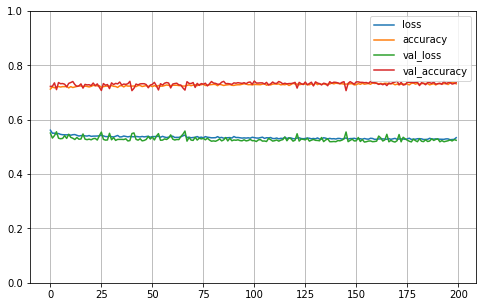

accuracy: 74.24%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5660 - accuracy: 0.7099 - val_loss: 0.5472 - val_accuracy: 0.7275
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5512 - accuracy: 0.7168 - val_loss: 0.5353 - val_accuracy: 0.7337
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5484 - accuracy: 0.7184 - val_loss: 0.6286 - val_accuracy: 0.6511
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5520 - accuracy: 0.7146 - val_loss: 0.5678 - val_accuracy: 0.7039
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5442 - accuracy: 0.7203 - val_loss: 0.5438 - val_accuracy: 0.7312
Epoch 6/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5460 - accuracy: 0.7226 - val_loss: 0.5367 - val_accuracy: 0.7368
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5490 - accuracy: 0.71

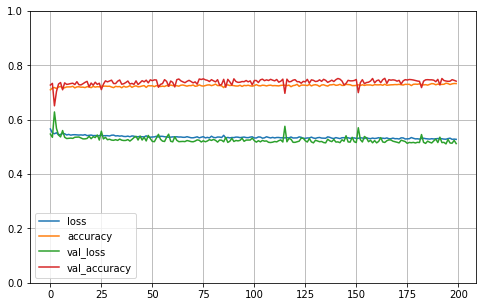

accuracy: 75.23%

5-way Cross Validation mean 74.77% (+/- 0.47%)
Done


In [70]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")